In [2]:
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

from pathlib import Path
from copy import deepcopy

import numpy as np
import pandas as pd

import sklearn
from sklearn.datasets import make_circles

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D  # 3D plots
import seaborn as sns

# plotting style
sns.set_style('white')
# for reproducibility

np.random.seed(seed=42)
results_path = Path('results')

if not results_path.exists():
    results_path.mkdir()

In [3]:
# Generate Random Data

# dataset params
N = 50000
factor = 0.1
noise = 0.1
n_iterations = 50000
learning_rate = 0.0001
momentum_factor = .5

# generate data by make_circles(Make a large circle containing a smaller circle in 2d)
X, y = make_circles(n_samples=N, shuffle=True, factor=factor, noise=noise)

# define outcome matrix
Y = np.zeros((N, 2))
for c in [0, 1]:
    Y[y == c, c] = 1

f'Shape of: X: {X.shape} | Y: {Y.shape} | y: {y.shape}'

'Shape of: X: (50000, 2) | Y: (50000, 2) | y: (50000,)'

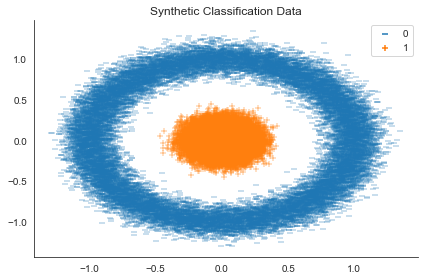

In [4]:
# Visualize Data
ax = sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, style=y, markers=['_', '+'])
ax.set_title('Synthetic Classification Data')
sns.despine()
plt.tight_layout()
plt.savefig(results_path / 'ffnn_data', dpi=300);

In [5]:
def logistic(z):
    """Logistic sigmoid function."""
    return 1 / (1 + np.exp(-z))


def hidden_layer(input_data, weights, bias):
    """Compute hidden activations"""
    return logistic(input_data @ weights + bias)


def softmax(z):
    """Softmax function"""
    return np.exp(z) / np.sum(np.exp(z), axis=1, keepdims=True)


def output_layer(hidden_activations, weights, bias):
    """Compute the output y_hat"""
    return softmax(hidden_activations @ weights + bias)

In [6]:
# Forward Propagation
def forward_prop(data, hidden_weights, hidden_bias, output_weights, output_bias):
    """Neural network as function."""
    hidden_activations = hidden_layer(data, hidden_weights, hidden_bias)
    return output_layer(hidden_activations, output_weights, output_bias)


def predict(data, hidden_weights, hidden_bias, output_weights, output_bias):
    """Predicts class 0 or 1"""
    y_pred_proba = forward_prop(data, hidden_weights, hidden_bias, output_weights, output_bias)
    return np.around(y_pred_proba)


def loss(y_hat, y_true):
    """Cross-entropy cost function"""
    return -(y_true * np.log(y_hat)).sum()


# Backpropagation - Loss Function Gradient
def loss_gradient(y_hat, y_true):
    """output layer gradient"""
    return y_hat - y_true

In [7]:
# Output Layer Gradients
def output_weight_gradient(H, loss_grad):
    """Gradients for the output layer weights"""
    return H.T @ loss_grad

# Output Bias Update
def output_bias_gradient(loss_grad):
    """Gradients for the output layer bias"""
    return np.sum(loss_grad, axis=0, keepdims=True)

# Hidden layer gradients
def hidden_layer_gradient(H, out_weights, loss_grad):
    """Error at the hidden layer. H * (1-H) * (E . Wo^T)"""
    return H * (1 - H) * (loss_grad @ out_weights.T)

# Hidden Weight Gradient
def hidden_weight_gradient(X, hidden_layer_grad):
    """Gradient for the weight parameters at the hidden layer"""
    return X.T @ hidden_layer_grad

# Hidden Bias Gradient
def hidden_bias_gradient(hidden_layer_grad):
    """Gradient for the bias parameters at the output layer"""
    return np.sum(hidden_layer_grad, axis=0, keepdims=True)

In [8]:
# Initialize Weights
def initialize_weights():
    """Initialize hidden and output weights and biases"""

    # Initialize hidden layer parameters
    # np.random.randn: create Gaussian standard normal distribution Matrix
    hidden_weights = np.random.randn(2, 3)
    hidden_bias = np.random.randn(1, 3)

    # Initialize output layer parameters
    output_weights = np.random.randn(3, 2)
    output_bias = np.random.randn(1, 2)
    return hidden_weights, hidden_bias, output_weights, output_bias

# Compute Gradients
def compute_gradients(X, y_true, w_h, b_h, w_o, b_o):
    """Evaluate gradients for parameter updates"""

    # Compute hidden and output layer activations
    hidden_activations = hidden_layer(X, w_h, b_h)
    y_hat = output_layer(hidden_activations, w_o, b_o)

    # Compute the output layer gradients
    loss_grad = loss_gradient(y_hat, y_true)
    out_weight_grad = output_weight_gradient(hidden_activations, loss_grad)
    out_bias_grad = output_bias_gradient(loss_grad)

    # Compute the hidden layer gradients
    hidden_layer_grad = hidden_layer_gradient(hidden_activations, w_o, loss_grad)
    hidden_weight_grad = hidden_weight_gradient(X, hidden_layer_grad)
    hidden_bias_grad = hidden_bias_gradient(hidden_layer_grad)

    return [hidden_weight_grad, hidden_bias_grad, out_weight_grad, out_bias_grad]

In [9]:
# Check Gradients

eps = 1e-4 # change individual parameters by +/- eps
params = initialize_weights() # initialize weights and biases
grad_params = compute_gradients(X, Y, *params) # Get all parameter gradients

# Check each parameter matrix
for i, param in enumerate(params):
    # Check each matrix entry
    rows, cols = param.shape
    for row in range(rows):
        for col in range(cols):
            # change current entry by +/- eps
            params_low = deepcopy(params)
            params_low[i][row, col] -= eps

            params_high = deepcopy(params)
            params_high[i][row, col] += eps

            # Compute the numerical gradient
            loss_high = loss(forward_prop(X, *params_high), Y)
            loss_low = loss(forward_prop(X, *params_low), Y)
            numerical_gradient = (loss_high - loss_low) / (2 * eps)

            backprop_gradient = grad_params[i][row, col]

            # Raise error if numerical and backprop gradient differ
            assert np.allclose(numerical_gradient, backprop_gradient), ValueError(
                    f'Numerical gradient of {numerical_gradient:.6f} not close to '
                    f'backprop gradient of {backprop_gradient:.6f}!')

print('No gradient errors found')

No gradient errors found


In [10]:
def update_momentum(X, y_true, param_list, Ms, momentum_term, learning_rate):
    """Update the momentum matrices."""
    # param_list = [hidden_weight, hidden_bias, out_weight, out_bias]
    gradients = compute_gradients(X, y_true, *param_list)
    return [momentum_term * momentum - learning_rate * grads for momentum, grads in zip(Ms, gradients)]

def update_params(param_list, Ms):
    """Update the parameters."""
    # param_list = [Wh, bh, Wo, bo] , Ms = [MWh, Mbh, MWo, Mbo]
    return [P + M for P, M in zip(param_list, Ms)]

def train_network(iterations=1000, lr=.01, mf=.1):
    # Initialize weights and biases
    param_list = list(initialize_weights())

    # Momentum Matrices = [MWh, Mbh, MWo, Mbo]
    Ms = [np.zeros_like(M) for M in param_list]

    train_loss = [loss(forward_prop(X, *param_list), Y)]
    for i in range(iterations):
        if i % 1000 == 0: print(f'{i:,d}', end=' ', flush=True)
        # Update the moments and the parameters
        Ms = update_momentum(X, Y, param_list, Ms, mf, lr)

        param_list = update_params(param_list, Ms)
        train_loss.append(loss(forward_prop(X, *param_list), Y))

    return param_list, train_loss

In [11]:
# for more tests with various parameters
# n_iterations = 20000
# results = {}
# for learning_rate in [.01, .02, .05, .1, .25]:
#     for momentum_factor in [0, .01, .05, .1, .5]:
#         print(learning_rate, momentum_factor)
#         trained_params, train_loss = train_network(iterations=n_iterations, lr=learning_rate, mf=momentum_factor)
#         results[(learning_rate, momentum_factor)] = train_loss[::1000]

# simple test
trained_params, train_loss = train_network(iterations=n_iterations, lr=learning_rate, mf=momentum_factor)

0 1,000 2,000 3,000 4,000 5,000 6,000 7,000 8,000 9,000 10,000 11,000 12,000 13,000 14,000 15,000 16,000 17,000 18,000 19,000 20,000 21,000 22,000 23,000 24,000 25,000 26,000 27,000 28,000 29,000 30,000 31,000 32,000 33,000 34,000 35,000 36,000 37,000 38,000 39,000 40,000 41,000 42,000 43,000 44,000 45,000 46,000 47,000 48,000 49,000 

In [12]:
hidden_weights, hidden_bias, output_weights, output_bias = trained_params

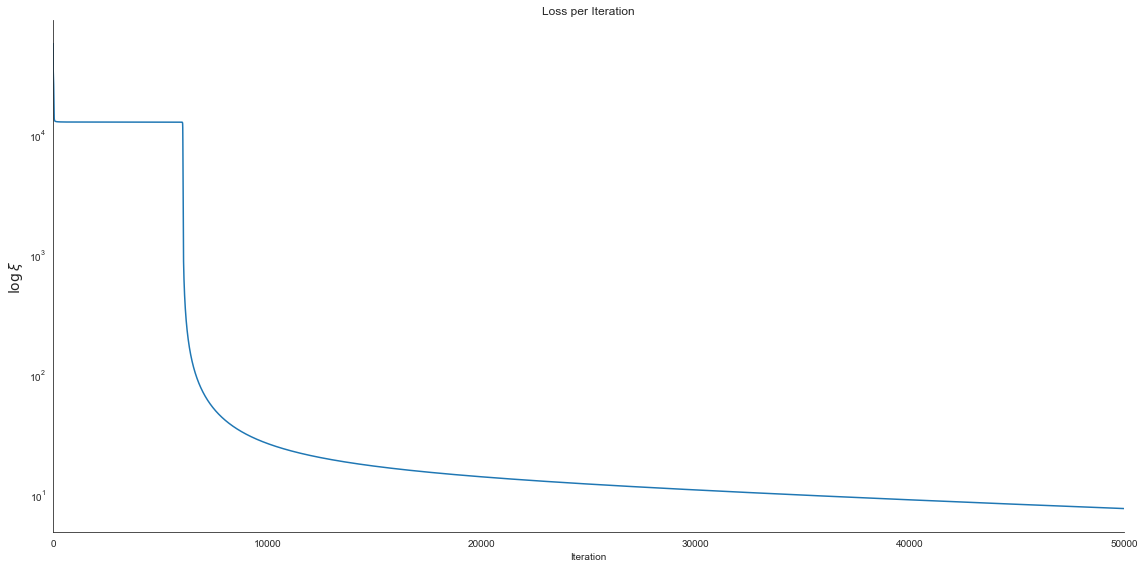

In [13]:
# Plot Training Loss
ax = pd.Series(train_loss).plot(figsize=(16, 8), title='Loss per Iteration', xlim=(0, n_iterations), logy=True)
ax.set_xlabel('Iteration')
ax.set_ylabel('$\\log \\xi$', fontsize=14)
sns.despine()
plt.tight_layout()
plt.savefig(results_path / 'ffnn_loss', dpi=300)

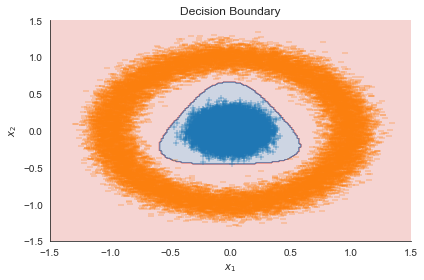

In [14]:
# Decision Boundary
n_vals = 200
x1 = np.linspace(-1.5, 1.5, num=n_vals)
x2 = np.linspace(-1.5, 1.5, num=n_vals)
xx, yy = np.meshgrid(x1, x2)  # create the grid

# Initialize and fill the feature space
feature_space = np.zeros((n_vals, n_vals))
for i in range(n_vals):
    for j in range(n_vals):
        X_ = np.asarray([xx[i, j], yy[i, j]])
        feature_space[i, j] = np.argmax(predict(X_, *trained_params))
# Create a color map to show the classification colors of each grid point
cmap = ListedColormap([sns.xkcd_rgb["pale red"], sns.xkcd_rgb["denim blue"]])

# Plot the classification plane with decision boundary and input samples
plt.contourf(xx, yy, feature_space, cmap=cmap, alpha=.25)

# Plot both classes on the x1, x2 plane
data = pd.DataFrame(X, columns=['$x_1$', '$x_2$']).assign(Class=pd.Series(y).map({0:'negative', 1:'positive'}))
sns.scatterplot(x='$x_1$', y='$x_2$', hue='Class', data=data, style=y, markers=['_', '+'], legend=False)
plt.title('Decision Boundary')
sns.despine()
plt.tight_layout()
plt.savefig(results_path / 'boundary', dpi=300);

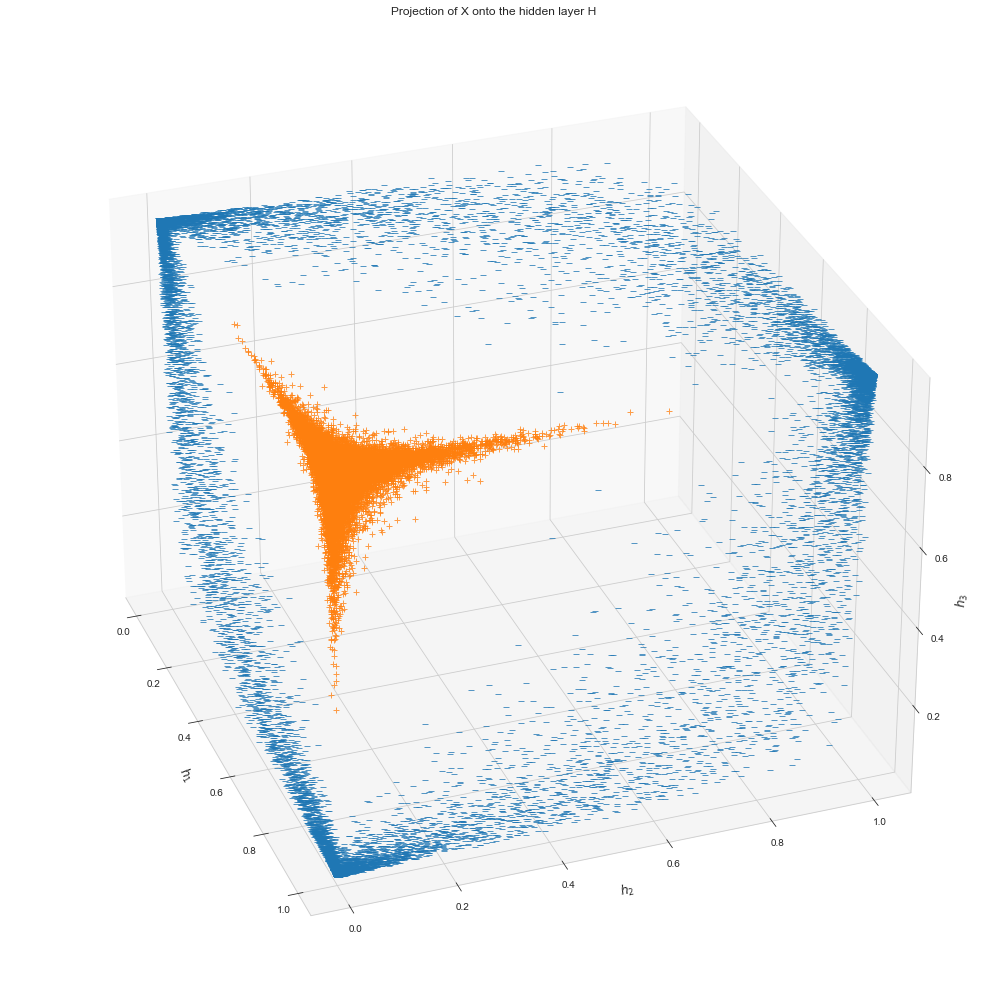

In [29]:
# Projection on Hidden Layer
n_vals = 25
x1 = np.linspace(-1.5, 1.5, num=n_vals)
x2 = np.linspace(-1.5, 1.5, num=n_vals)
xx, yy = np.meshgrid(x1, x2)  # create the grid
X_ = np.array([xx.ravel(), yy.ravel()]).T

fig = plt.figure(figsize=(16, 14))
with sns.axes_style("whitegrid"):
    ax = fig.add_subplot(projection='3d') # code updated from "ax = Axes3D(fig)"

ax.plot(*hidden_layer(X[y == 0], hidden_weights, hidden_bias).T, '_', label='negative class', alpha=0.75)
ax.plot(*hidden_layer(X[y == 1], hidden_weights, hidden_bias).T, '+', label='positive class', alpha=0.75)

ax.set_xlabel('$h_1$', fontsize=12)
ax.set_ylabel('$h_2$', fontsize=12)
ax.set_zlabel('$h_3$', fontsize=12)
ax.view_init(elev=30, azim=-20)
# plt.legend(loc='best')
plt.title('Projection of X onto the hidden layer H')
sns.despine()
plt.tight_layout()
plt.savefig(results_path / 'projection3d', dpi=300)

In [26]:
hidden_layer(X[y == 1], hidden_weights, hidden_bias).T

array([[0.96356497, 0.965103  , 0.91845459, ..., 0.9406598 , 0.98895816,
        0.98561206],
       [0.00599589, 0.03737653, 0.01147309, ..., 0.1047554 , 0.02603623,
        0.01680322],
       [0.95764777, 0.99264147, 0.99041176, ..., 0.9985868 , 0.96552065,
        0.95957692]])

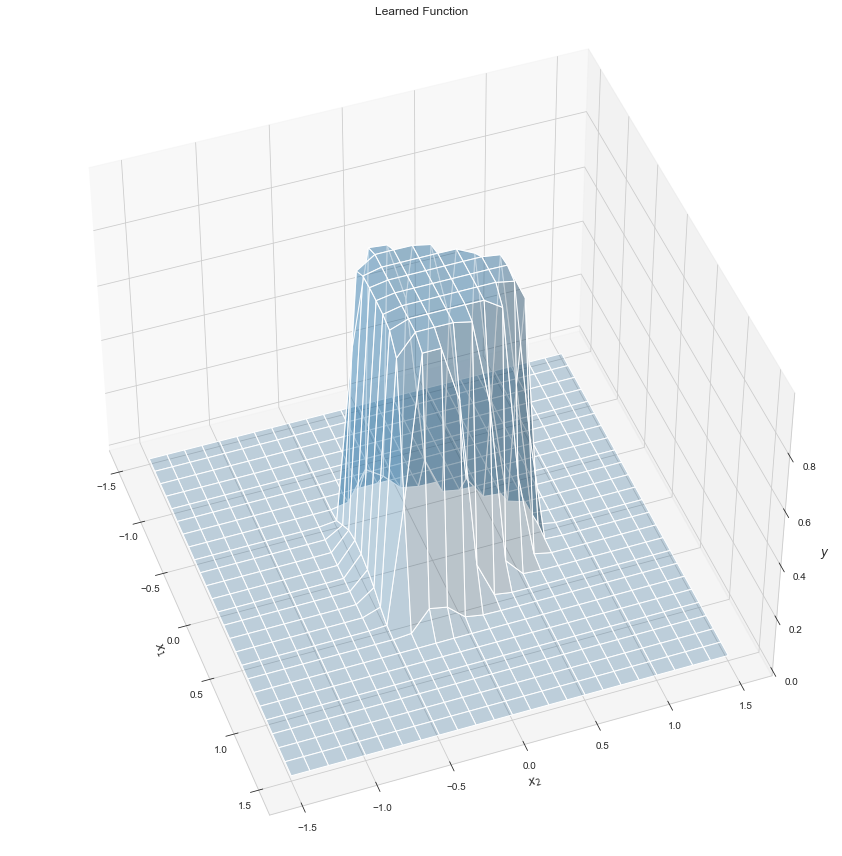

In [30]:
zz = forward_prop(X_, hidden_weights, hidden_bias, output_weights, output_bias)[:, 1].reshape(25, -1)

fig = plt.figure(figsize=(14, 12))
with sns.axes_style("whitegrid"):
    ax = fig.add_subplot(projection='3d')
ax.plot_surface(xx, yy, zz, alpha=.25)
ax.set_title('Learned Function')
ax.set_xlabel('$x_1$', fontsize=12)
ax.set_ylabel('$x_2$', fontsize=12)
ax.set_zlabel('$y$', fontsize=12)
ax.view_init(elev=45, azim=-20)
sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'surface', dpi=300);